In [1]:
# Showing images in notebook
%pylab inline
# Automatic differentiation
import tensorflow as tf
# Vector operations
import numpy as np
# Image handling
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


## 1. Load content and style images

### Loading
Load images from disk into vectors

In [49]:
# Declare filepaths of our images on disk.
filenames = ['./images/content.jpg', './images/style.jpg']
filename_queue = tf.train.string_input_producer(filenames, shuffle=False)

# Read images from disk.
reader = tf.WholeFileReader()
key, value = reader.read(filename_queue)

# Convert image to tensor.
image_queue = tf.image.decode_jpeg(value, channels=3)

# Dict for storing our image tensors
images = {}

with tf.Session():
    # Start populating the filename queue.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Perform image decode operation and resize.
    images['content'] = image_queue.eval()
    images['style'] = image_queue.eval()
    
    # Stop queue runners.
    coord.request_stop()
    coord.join(threads)

#### Content image
by Ethan Sykes: https://unsplash.com/?photo=iISyBKOT2D0

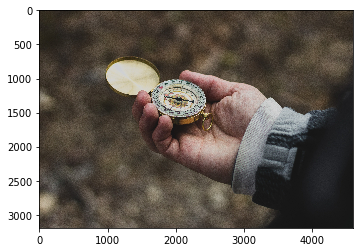

(3192, 4598, 3)


In [50]:
image = images['content']
imshow(Image.fromarray(image.astype('uint8')))
show()
print(image.shape)

#### Style image

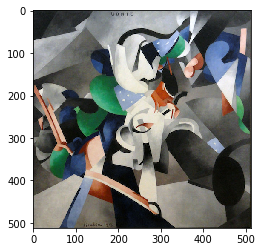

(512, 512, 3)


In [51]:
image = images['style']
imshow(Image.fromarray(image.astype('uint8')))
show()
print(image.shape)

### Preprocessing

In [52]:
# Helper to print all images in our dict
def print_images():
  for _, image in images.items():
    imshow(Image.fromarray(image[0].astype('uint8')))
    show()
    print(image.shape)

#### Scale

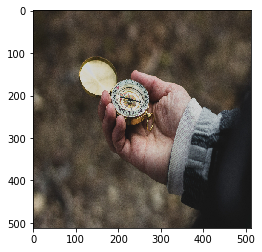

(1, 512, 512, 3)


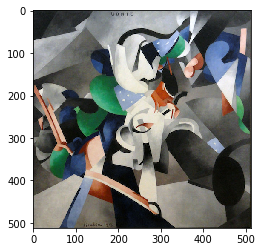

(1, 512, 512, 3)


In [57]:
with tf.Session():
    images['content'] = tf.image.resize_images(images['content'], [512, 512]).eval()
    images['style'] = tf.image.resize_images(images['style'], [512, 512]).eval()

images['content'] = array(images['content']).reshape([1, 512, 512, 3])
images['style'] = array(images['style']).reshape([1, 512, 512, 3])
print_images()

#### Subtract mean value
https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3#gistcomment-1616734

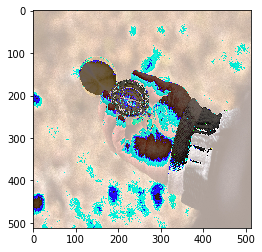

(1, 512, 512, 3)


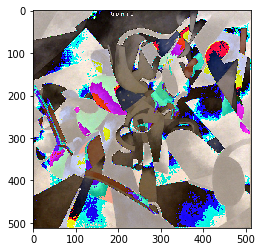

(1, 512, 512, 3)


In [58]:
mean_pixel = [103.939, 116.779, 123.68]
images['content'] = images['content'] - mean_pixel
images['style'] = images['style'] - mean_pixel
print_images()

### 2. load pre-trained VGG
Using the parts of https://github.com/anishathalye/neural-style that load the pre-trained VGG19 network from a Matlab file into tensors.

Expects _imagenet-vgg-verydeep-19.mat_ to be in the same directory. [Download](http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat) it first.

In [13]:
import vgg

vgg_weights = vgg.load_net('imagenet-vgg-verydeep-19.mat')

### 3. feedforward content and style to get activations for the right layers

+ optimize white noise image to have the same activations as the style image and show that optimized image (it should represent the extracted style)

In [21]:
CONTENT_LAYERS = ['relu4_2']
STYLE_LAYERS = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

In [60]:
# compute content features in feedforward mode
content_features = {}

g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    image = tf.placeholder('float', shape=images['content'].shape)
    net = vgg.net_preloaded(vgg_weights, image, 'max')
    for layer in CONTENT_LAYERS:
        content_features[layer] = net[layer].eval(feed_dict={image: images['content']})

In [61]:
# compute style features in feedforward mode

style_features = {}

g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    image = tf.placeholder('float', shape=images['style'].shape)
    net = vgg.net_preloaded(vgg_weights, image, 'max')
    for layer in STYLE_LAYERS:
        features = net[layer].eval(feed_dict={image: images['style']})
        features = np.reshape(features, (-1, features.shape[3]))
        gram = np.matmul(features.T, features) / features.size
        style_features[layer] = gram

### 4. Define losses

### 5. Backprop gradients of total loss into white noise image (or content image)
use L-BFGS optimizer: https://github.com/tensorflow/tensorflow/issues/446#issuecomment-302352639

Weight settings according to https://github.com/leongatys/PytorchNeuralStyleTransfer/blob/master/NeuralStyleTransfer.ipynb)

Optimization started...

  content loss: 1.04219e+06

    style loss: 6.81951e+06

       tv loss: 26.234

    total loss: 7.86172e+06

Iteration    1/ 100

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 806308.125000
  Number of iterations: 101
  Number of functions evaluations: 110
  content loss: 494676

    style loss: 267606

       tv loss: 44026.7

    total loss: 806308



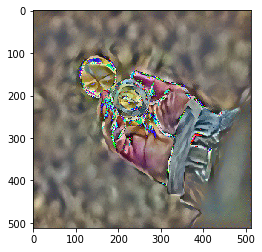

Iteration    2/ 100



KeyboardInterrupt: 

In [88]:
def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

# make stylized image using backpropogation
with tf.Graph().as_default():
    # Generate noise input
    noise = np.random.normal(size=images['content'].shape, scale=np.std(images['content']) * 0.1)
    initial = tf.random_normal(images['content'].shape) * 0.256
    image = tf.Variable(initial)
    net = vgg.net_preloaded(vgg_weights, image, 'max')

    # content loss
    content_layer_weight = 1e0

    content_loss = 0
    content_losses = []
    for content_layer in CONTENT_LAYERS:
        content_losses.append(content_layer_weight * 5e0 * (2 * tf.nn.l2_loss(
                net[content_layer] - content_features[content_layer]) /
                content_features[content_layer].size))
    from functools import reduce
    content_loss += reduce(tf.add, content_losses)
    
    # style loss
    style_weight = 5e2
    style_layers_weights = [1e3/n**2 for n in [64,128,256,512,512]]
    style_blend_weights = [1.0]
    
    style_loss = 0
    for i in range(len(STYLE_LAYERS)):
        style_losses = []
        for j, style_layer in enumerate(STYLE_LAYERS):
            layer = net[style_layer]
            _, height, width, number = map(lambda i: i.value, layer.get_shape())
            size = height * width * number
            feats = tf.reshape(layer, (-1, number))
            gram = tf.matmul(tf.transpose(feats), feats) / size
            style_gram = style_features[style_layer]
            style_losses.append(style_layers_weights[j] * 2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
        style_loss += style_weight * 1.0 * reduce(tf.add, style_losses)

    # total variation denoising
    tv_weight = 1e2
    
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])
    tv_loss = tv_weight * 2 * (
            (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
                tv_y_size) +
            (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
                tv_x_size))
    # overall loss
    loss = content_loss + style_loss + tv_loss

    # optimizer setup
    train_step = tf.contrib.opt.ScipyOptimizerInterface(
                loss,
                method='L-BFGS-B',
                options={'maxiter': 10}) # tf.train.AdamOptimizer(1e1, 0.9, 0.999, 1e-08).minimize(loss)

    def print_progress():
        print('  content loss: %g\n' % content_loss.eval())
        print('    style loss: %g\n' % style_loss.eval())
        print('       tv loss: %g\n' % tv_loss.eval())
        print('    total loss: %g\n' % loss.eval())

    # optimization
    best_loss = float('inf')
    best = None
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('Optimization started...\n')
        
        checkpoint_iterations = 1
        
        print_iterations = 1
        if (print_iterations and print_iterations != 0):
            print_progress()
        
        iterations = 100
        for i in range(iterations):
            print('Iteration %4d/%4d\n' % (i + 1, iterations))
            train_step.minimize(sess) # train_step.run()

            last_step = (i == iterations - 1)
            if last_step or (print_iterations and i % print_iterations == 0):
                print_progress()

            if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
                this_loss = loss.eval()
                if this_loss < best_loss:
                    best_loss = this_loss
                    best = image.eval()

                img_out = best.reshape(shape[1:]) + mean_pixel

                imshow(Image.fromarray(img_out.astype('uint8')))
                show()

